In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data.drop(columns=["price"])
y = data["price"]
for col in ["cityname", "state"]:
    X[col] = X[col].astype("category")


## Daten
Es werden states als auch cities als kategoriale Features mitgegeben --> XGBoost kann damit anscheinend umgehen

Zum Testen welche Features gebraucht werden

In [4]:
"""import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data[["square_feet", "state", "cityname", "bedrooms", "bathrooms"]]
y = data["price"]
"""

'import pandas as pd\nfrom sklearn.preprocessing import StandardScaler\n\ndata = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")\n\n# Features und Ziel\nX = data[["square_feet", "state", "cityname", "bedrooms", "bathrooms"]]\ny = data["price"]\n'

## 🚀 Hyperparameter des GradientBoostingRegressor

Der **Gradient Boosting Regressor (GBR)** ist eine **sequenzielle Ensemble-Methode**, die schwache Modelle (typischerweise Entscheidungsbäume) iterativ kombiniert. Die Parameter definieren das Suchgitter (`gbr_params`) für die Optimierung in der Nested Cross-Validation.

| Parameter | Beschreibung | Im Code definierte Werte |
| :--- | :--- | :--- |
| **`n_estimators`** | Die **Anzahl der Boosting-Stufen** (Anzahl der sequenziell hinzugefügten schwachen Lerner, d.h. Bäume). | `[5, 50]` |
| **`learning_rate`** | Die **Schrumpfungsrate** ($\eta$). Skaliert den Beitrag jedes Baumes. Ein kleinerer Wert erfordert mehr `n_estimators`, verbessert aber oft die Generalisierung. | `[0.1, 0.2]` |
| **`max_depth`** | Die **maximale Tiefe** jedes einzelnen Entscheidungsbaums (des *schwachen Lerners*). GBR verwendet meist flache Bäume (z.B. Tiefe 3-5). | `[3, 5, 7]` |
| **`min_samples_split`** | Die **minimale Anzahl von Datenpunkten** in einem internen Knoten, die für eine Teilung erforderlich ist. Dient zur Kontrolle der Baumkomplexität. | `[5, 10]` |

---

### 💡 Erläuterung der Boosting-Strategie



Gradient Boosting arbeitet, indem es sequentielle Bäume aufbaut, wobei jeder neue Baum versucht, die **Restfehler** (Residuen) des vorherigen Ensembles zu korrigieren.

1.  **`n_estimators`** und **`learning_rate`** steuern zusammen die **Gesamtstärke** des Modells und die Geschwindigkeit des Lernprozesses.
2.  **`max_depth`** und **`min_samples_split`** steuern die **Komplexität** jedes einzelnen, schwachen Entscheidungsbaums, der zur Korrektur der Residuen verwendet wird.

In [5]:
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
    # alle CPU-Kerne nutzen
)

# Hyperparameter-Grid
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7,10,None],
    "learning_rate": [0.05, 0.1, 0.2],
    #"subsample": [0.8, 1.0],
    #"colsample_bytree": [0.8, 1.0],
    #"gamma": [0, 1],  # Minimum Loss Reduction
    #"reg_alpha": [0, 0.1],  # L1 Regularisierung
    #"reg_lambda": [1, 5]    # L2 Regularisierung
}

xgb_cv = NestedCVRegressorWithTargetEncoding(xgb_model, xgb_params, encode_cols=[], scaler=None, outer_splits=10, inner_splits=5, random_state=42)

print("Starte XGBoost Nested CV...")
xgb_cv.run(X, y, output=True)

print("\n--- XGBoost Ergebnisse ---")
print("Mean R²:", xgb_cv.get_mean_r2())
print("Best params:", xgb_cv.get_best_params())


Starte XGBoost Nested CV...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 1/10 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300} | Fit Time: 7.688s | Outer R²: 0.831 | MSE: 79445.663
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 2/10 | Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 300} | Fit Time: 19.431s | Outer R²: 0.841 | MSE: 75579.309
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 3/10 | Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 300} | Fit Time: 19.454s | Outer R²: 0.838 | MSE: 74267.389
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 4/10 | Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 300} | Fit Time: 19.567s | Outer R²: 0.838 | MSE: 75989.235
Fitting 5 folds for each of 45 candidates, totalling 2

# Erkenntnisse
Ohne Scaler und ohne target ENcoding am besten

Vorteil: Kann direkt mit categorcals umgehen

In [6]:
number_outer_cv_splits = 10
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['XGBOOST'] * number_outer_cv_splits
model_evaluation['R_2'] = xgb_cv.get_r2_scores()
model_evaluation['MSE'] = xgb_cv.get_mse_scores()
model_evaluation["runtime"] = xgb_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,XGBOOST,0.831064,79445.662674,7.688294
1,2,XGBOOST,0.840994,75579.308784,19.430595
2,3,XGBOOST,0.837516,74267.388618,19.454498
3,4,XGBOOST,0.838478,75989.234884,19.567134
4,5,XGBOOST,0.836856,78428.351224,19.388602
5,6,XGBOOST,0.844069,70191.059898,19.700462
6,7,XGBOOST,0.841222,74010.235249,20.065143
7,8,XGBOOST,0.824656,81012.100676,19.335702
8,9,XGBOOST,0.834733,77625.841589,19.710214
9,10,XGBOOST,0.849647,69017.637099,7.250990


In [7]:
model_evaluation.to_pickle('benchmarking/XGBOOST.pkl')

-----------------------------------------------------------------------------------------------------------------------------------------------
Teste ein sparse Modell

In [31]:
X_sparse = data[["cityname", "state", "square_feet"]]
for col in ["cityname", "state"]:
    X_sparse[col] = X_sparse[col].astype("category")

from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding
import xgboost as xgb

xgb_model_sparse = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
    # alle CPU-Kerne nutzen
)

# Hyperparameter-Grid
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7,10,None],
    "learning_rate": [0.05, 0.1, 0.2],
    #"subsample": [0.8, 1.0],
    #"colsample_bytree": [0.8, 1.0],
    #"gamma": [0, 1],  # Minimum Loss Reduction
    #"reg_alpha": [0, 0.1],  # L1 Regularisierung
    #"reg_lambda": [1, 5]    # L2 Regularisierung
}

xgb_cv_sparse = NestedCVRegressorWithTargetEncoding(xgb_model_sparse, xgb_params, encode_cols=[], scaler=None, outer_splits=10, inner_splits=5, random_state=42)

print("Starte XGBoost Nested CV...")
xgb_cv_sparse.run(X_sparse, y, output=True)

print("\n--- XGBoost Ergebnisse ---")
print("Mean R²:", xgb_cv_sparse.get_mean_r2())
print("Best params:", xgb_cv_sparse.get_best_params())

C:\Users\User\AppData\Local\Temp\ipykernel_18268\3427084675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sparse[col] = X_sparse[col].astype("category")
C:\Users\User\AppData\Local\Temp\ipykernel_18268\3427084675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sparse[col] = X_sparse[col].astype("category")


Starte XGBoost Nested CV...
Fitting 5 folds for each of 45 candidates, totalling 225 fits


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Loc

Outer Fold 1/10 | Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300} | Fit Time: 7.036s | Outer R²: 0.787 | MSE: 99938.472
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 2/10 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': None, 'model__n_estimators': 300} | Fit Time: 4.957s | Outer R²: 0.792 | MSE: 98633.559
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 3/10 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 300} | Fit Time: 3.892s | Outer R²: 0.787 | MSE: 97339.214
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 4/10 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 300} | Fit Time: 3.736s | Outer R²: 0.795 | MSE: 96675.659
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Outer Fold 5/10 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': None

In [ ]:
number_outer_cv_splits = 10
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['XGBOOST_sparse'] * number_outer_cv_splits
model_evaluation['R_2'] = xgb_cv_sparse.get_r2_scores()
model_evaluation['MSE'] = xgb_cv_sparse.get_mse_scores()
model_evaluation["runtime"] = xgb_cv_sparse.get_fit_times()
model_evaluation

------------------------------------------------------------------------------------------------------------------------------------------

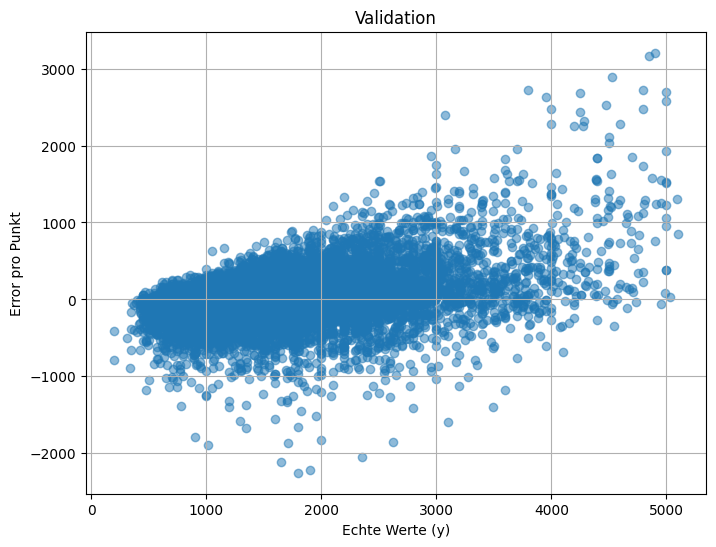

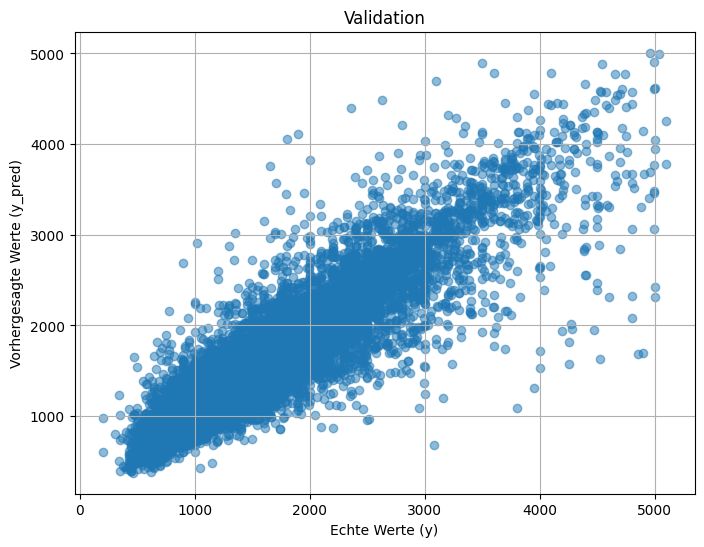

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


best_params = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
xgb_final_model = xgb.XGBRegressor(
    objective='reg:squarederror', learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'],
    random_state=42, n_jobs=-1, enable_categorical=True)
xgb_final_model.fit(X_train, y_train)
# Vorhersagen
y_pred = xgb_final_model.predict(X_val)

import matplotlib.pyplot as plt
# RMSE pro Punkt (Absolutfehler oder quadratischer Fehler)
rmse_per_point = (y_val - y_pred)  # = |y_i - y_pred_i|

# Plot
plt.figure(figsize=(8,6))
plt.scatter(y_val, rmse_per_point, alpha=0.5)
plt.xlabel("Echte Werte (y)")
plt.ylabel("Error pro Punkt")
plt.title("Validation")
plt.grid(True)
plt.show()
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Echte Werte (y)")
plt.ylabel("Vorhergesagte Werte (y_pred)")
plt.title("Validation")
plt.grid(True)
plt.show()

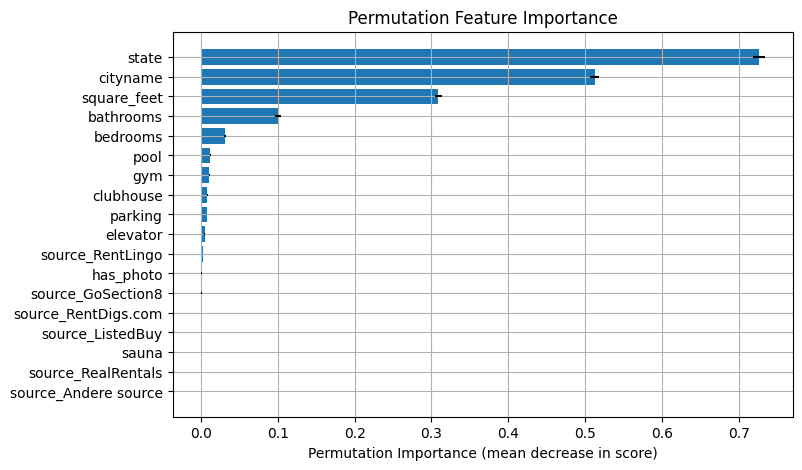

,feature,importance_mean,importance_std
12,source_Andere source,-0.000085,0.000033
15,source_RealRentals,-0.000050,0.000026
9,sauna,0.000000,0.000000
14,source_ListedBuy,0.000034,0.000050
16,source_RentDigs.com,0.000168,0.000064
13,source_GoSection8,0.000614,0.000095
2,has_photo,0.000651,0.000223
17,source_RentLingo,0.002496,0.000285
10,elevator,0.004916,0.000423
8,parking,0.007807,0.000553


In [ ]:
from permutation_importance_ import permutation_importance_analysis
permutation_importance_analysis(xgb_final_model, X_val, y_val, show_plot=True, save_as_pkl=True, file_name="XGBoost.pkl")

# XGBoost und kategoriale Features – Zusammenfassung

## 1. Umgang mit kategorialen Features

XGBoost kann **kategoriale Features nativ** verarbeiten, wenn `enable_categorical=True` gesetzt ist.

- **Keine One-Hot-Encoding** notwendig.  
- Kategorien werden intern als Sets behandelt.  
- Jeder Split teilt die Kategorien in zwei Mengen auf:




- Ziel: Split, der den Loss maximal reduziert.

---

## 2. Effiziente Split-Auswahl

Direktes Prüfen aller möglichen Teilmengen ist **exponentiell** (~2^(K-1) für K Kategorien).  
XGBoost löst das so:

1. Für jede Kategorie c wird die Summe der Gradienten \(G_c = \sum g_i\) und Hessians \(H_c = \sum h_i\) berechnet.  
2. Kategorien werden nach **G/H** sortiert:

$$
\frac{G_c}{H_c} \quad \text{(optimaler Leaf-Wert der Kategorie)}
$$

3. Nur die **K-1 möglichen Splits** entlang dieser Reihenfolge werden getestet:  
--> **lineare Anzahl an Splits** durchsuchen anstatt exponentiell vieler




- **Gain** für jeden Split:

$$
\text{Gain} = \frac{1}{2} \Big(
\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L+G_R)^2}{H_L+H_R+\lambda}
\Big) - \gamma
$$

- Split mit **maximalem Gain** wird gewählt.  
--> man kann zeigen, dass der Split mit maximalem Gain durch einen Split entlang der Reihenfolge (Kategorien aufsteigend nach G/H sortiert) gefunden wird

---

## 3. Gain und Summe der quadrierten Abweichungen (SSE)

- Bei MSE-Regression:

$$
L = \frac12 (y_i - \hat y_i)^2
$$

- Gradienten und Hessians:

$$
g_i = \hat y_i - y_i \quad , \quad h_i = 1
$$
Hierbei ist $\hat y_i$ die Vorhersage von $y_i$ vor dem Aufbau des neuen Baumes. Der Gradient ist also genau das Residuum, das gefittet werden soll

- Gain reduziert sich auf:

$$
\text{Gain} \propto \text{SSE}_{parent} - (\text{SSE}_{left} + \text{SSE}_{right})
$$


- **Intuition:** Maximieren des Gains = Minimieren der Summe der SSE in den Kindern.  
- Damit wählt XGBoost **denselben Split wie klassisches Gradient Boosting** bei MSE:

$$
\text{maximize Gain} \quad \Leftrightarrow \quad \text{min } (\text{SSE}_L + \text{SSE}_R)
$$
$\text{SSE}_L = \sum_{i \in L} (w_L - r_i)^2$, where $w_L$ is the leaf value und $r_i$ is the residual which should be fitted
- Leaf-Werte:

$$
w_\text{Leaf} = - \frac{\sum g_i}{\sum h_i + \lambda} \approx \text{Mittelwert der Residuen im Fall von MSE-Regression} 
$$
($\lambda$ ist Regularisierungsparameter)

---

## 4. Parallele zu klassischem Gradient Boosting

- Klassisches Gradient Boosting auf MSE:  
  - Split-Kriterium = Minimierung der Summe der quadrierten Abweichungen in den Kinderknoten  
  - Leaf-Werte = Mittelwert der Residuen  

- XGBoost auf MSE:  
  - Split-Kriterium = Maximierung des Gains  
  - Leaf-Werte = optimaler Newton-Schritt (≈ Mittelwert der Residuen)  
  - Exponentiell viele Set-Splits bei Kategorien werden durch **G/H-Sortierung** auf linear reduziert  

- Fazit: **XGBoost ≈ Gradient Boosting bei MSE**, nur effizienter und mit zusätzlichen Regularisierungen.

---

## 5. Vorteile von XGBoost gegenüber klassischem Gradient Boosting

- Native Unterstützung für **kategoriale Features**  
- **Schnelleres Training** (Histogramm-basiert, parallele Berechnungen)  
- **Regularisierung** (L1/L2 auf Leaf-Werte)  
- **Early stopping** und minimale Gain-Schwelle (\(\gamma\)) verhindern Overfitting  
- Flexibel für **verschiedene Loss-Funktionen**, nicht nur MSE

---


----------------------------------------------------------------------------------------------------
# Gradient Boosting / XGBoost – Prüfungszusammenfassung

## 1. Warum Gradient Boosting / XGBoost?
- Ensemble aus vielen **schwachen Entscheidungsbäumen**
- Bäume werden **sequenziell** trainiert
- Jeder neue Baum korrigiert die **Fehler (Residuals)** der vorherigen
- Sehr gut für **strukturierte/tabellarische Daten**
- Erkennt **nichtlineare Zusammenhänge** und **Feature-Interaktionen**
- XGBoost zusätzlich:
  - Hohe **Rechen­effizienz**
  - **Regularisierung** (L1/L2) gegen Overfitting
  - Gute Skalierbarkeit

---

## 2. Grundidee Gradient Boosting (Regression)
- Start mit konstantem Modell (z. B. Mittelwert)
- Iterativ:
  - Berechne Residuen / Gradienten der Loss-Funktion
  - Trainiere Baum auf diese Fehler
  - Addiere Baum mit Lernrate `η`
- Ziel: **Minimierung einer differentiierbaren Loss-Funktion**

---

## 3. Klassische Entscheidungsbäume
- Unterstützen **nur numerische Schwellen-Splits**:
  - `x_j ≤ t` vs. `x_j > t`
- Keine native Unterstützung für kategoriale Variablen
- Kategorien müssen kodiert werden:
  - One-Hot-Encoding
  - Ordinal-Encoding

---

## 4. Probleme mit One-Hot-Encoding bei Bäumen
- Erzeugt **viele zusätzliche Features**
- Erhöht **Modellkomplexität**
- Führt oft zu:
  - **tieferen Bäumen**
  - längeren Trainingszeiten
  - höherem Overfitting-Risiko
- Ein logischer Kategorien-Split wird in **mehrere binäre Splits zerlegt**

---

## 5. Kategoriale Variablen in XGBoost
- Native Unterstützung (`enable_categorical=True`)
- Kategorien werden als **diskrete Werte** behandelt
- Splits der Form:
  - `x_j ∈ S` vs. `x_j ∉ S`
- Kein künstliches Ordnen der Kategorien notwendig

---

## 6. Gibt es nicht 2^K mögliche Kategorie-Splits?
- **Theoretisch ja**
- **Praktisch nein**, weil:
  - Kategorien nach Zielwert-Effekt sortiert werden
  - Reduktion auf **K − 1 sinnvolle Split-Kandidaten**
  - Histogramm-basierte Split-Suche
  - Regularisierung & Gain-Schwellen

---

## 7. Warum ist XGBoost schneller?
- Keine hochdimensionale One-Hot-Repräsentation
- Weniger Features → weniger Split-Kandidaten
- Histogramm-basierte Approximation der Splits
- Gute Cache-Nutzung
- Parallelisierte Split-Berechnung